In [132]:
import warnings
from statsbombpy.api_client import NoAuthWarning
warnings.simplefilter('ignore', NoAuthWarning)
from socceraction.data.statsbomb import StatsBombLoader

api = StatsBombLoader(getter="remote", creds={"user": "", "passwd": ""})

Real Valladolid vs Barcelona (La Liga Regular Season - 2012/2013)
Bayern Munich vs Chelsea (Champions League Final - 2011/2012)
Rayo Vallecano vs Barcelona (La Liga Regular Season - 2013/2014)
AC Milan vs Liverpool (Champions League Final - 2004/2005)


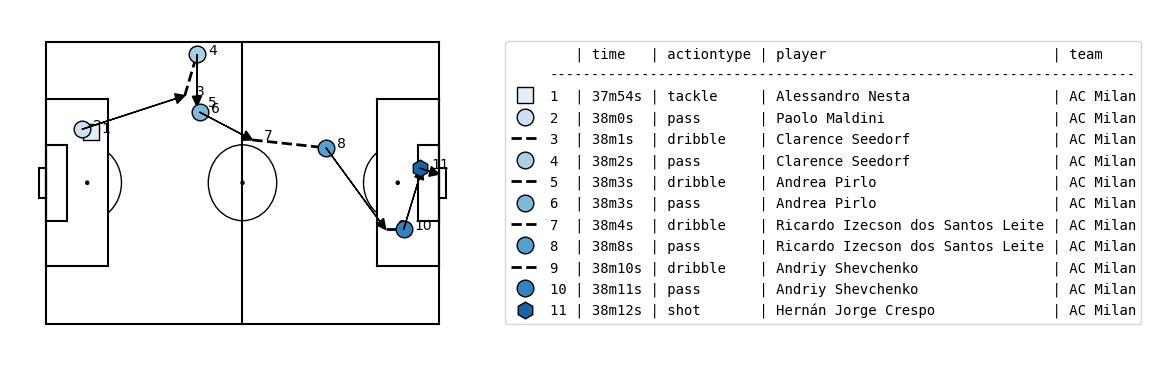

In [133]:
import random
import socceraction.spadl as spadl
import matplotsoccer
import pandas as pd

def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

def find_goal_from_the_back(df_actions, c_string):

    clean_build_ups = []
    min_passes = 5  # Minimum number of passes in a clean build-up
    max_passes = 20 # Not too confusing

    for i, row in df_actions.iterrows():
        sequence = [row]

        if row['start_x'] < 20:

            for j in range(i+1, len(df_actions)):
                next_row = df_actions.iloc[j]
                if next_row['team_id'] == row['team_id']:
                    sequence.append(next_row)
                    row = next_row
                else:
                    break

            if len(sequence) >= min_passes and len(sequence) <= max_passes and sequence[-1]['type_name'] == 'shot' and sequence[-1]['start_x'] > 50 and sequence[-1]['result_id'] == 1:
                clean_build_ups.append(sequence)

    for sequence in clean_build_ups:

        if not sequence:
            print(c_string)
            return True
        else:
            df = pd.DataFrame(sequence, columns=df_actions.columns)

            df["nice_time"] = df.apply(nice_time, axis=1)
            labels = df[["nice_time", "type_name", "player_name", "team_name"]]

            print(c_string)

            ax = matplotsoccer.actions(
                location=df[["start_x", "start_y", "end_x", "end_y"]],
                action_type=df.type_name,
                team= df.team_name,
                result= df.result_name == "success",
                label=labels,
                labeltitle=["time", "actiontype", "player", "team"],
                zoom=False,
                figsize=6
            )

            return False
        
    print(c_string)
    return True

loop = True

while loop:

    loop = False

    df_competitions = api.competitions()
    random_row = df_competitions.sample(1)

    competition_id = random_row['competition_id'].item()
    season_id = random_row['season_id'].item()
    competition_name = random_row['competition_name'].item()
    season_name = random_row['season_name'].item()

    df_games = api.games(competition_id=competition_id, season_id=season_id)
    
    all_teams = list(df_games['home_team_id'].unique())
    team_id = random.choice(all_teams)

    df_games = df_games[(df_games['away_team_id'] == team_id) | (df_games['home_team_id'] == team_id)]
    all_games = list(df_games['game_id'])
    g = random.choice(all_games)
    
    c_stage = df_games[df_games['game_id'] == g]['competition_stage'].item()
    df_teams = api.teams(game_id=g)
    df_players = api.players(game_id=g)
    df_events = api.events(game_id=g)
    team_name = df_events[df_events['team_id'] == team_id]['team_name'].iloc[0]
    teams = list(df_events['team_name'].unique())
    teams.remove(team_name)

    df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=team_id)
    df_actions = (
    spadl
    .add_names(df_actions)
    .merge(api.teams(game_id=g))
    .merge(api.players(game_id=g))
    )
    df_actions = df_actions.sort_values(by=['period_id', 'time_seconds'], ascending=[True, True]).reset_index(drop=True)

    c_string = f"{team_name} vs {teams[0]} ({competition_name} {c_stage} - {season_name})"

    loop = find_goal_from_the_back(df_actions, c_string)

    